In [3]:
# Dependencias Generales
import os
import gc
import nibabel as nib
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Dependencias de PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

# Dependencias de Fastai
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader
from fastai.vision.models import resnet34
from fastai.losses import L1LossFlat # MAE Loss for flatten (lineal)
from fastai.metrics import mae, BalancedAccuracy, accuracy
from fastai.test_utils import *
from fastai.vision.all import *

In [5]:
# Fijar la semilla de PyTorch
torch.manual_seed(42)

# Fijar la semilla de NumPy
np.random.seed(42)

# Preprocesado

In [6]:
def arrayPaths(directory = '/kaggle/input'):
  """
   Recorrer recursivamente el directorio actual guardando los paths en un array.
   Ignorar metastasis.

  """
  paths = []

  # Recorre el directorio y sus subdirectorios, solo nivel superior
  for root, dirs, files in os.walk(directory):

      # Recorre las carpetas de primer nivel
      for subdir in dirs:
          subdir_path = os.path.join(root, subdir)
          seg_path = ""
          file_paths = []
          some_empty = False

          # Recorre los archivos dentro de las carpetas de primer nivel
          for file in os.listdir(subdir_path):
              file_path = os.path.join(subdir_path, file)
            
              if os.path.getsize(file_path) < 1: # Evitar archivos corruptos
                  some_empty = True
              if "seg" in file:  # Archivo de segmentación
                  seg_path = file_path
              else:
                  file_paths.append(file_path)

          # Agregar las rutas de archivos al array principal
          if "nii" in seg_path and not some_empty:
            paths.append((sorted(file_paths), seg_path))

  return paths

In [7]:
mri_paths = arrayPaths()

## Dividiendo en conjuntos de test, entrenamiento y validación

En este apartado dividimos el array global de ejemplos en datos de prueba (entrenamiento + validación) y test utilizando un esquema de $70\%$ y $30\%$. A su vez dividimos los datos de prueba en entrenamiento y validación siguiendo el mismo esquema.

In [8]:
test_size = int(0.3 * len(mri_paths))
mri_prueba, mri_test = random_split(mri_paths, [len(mri_paths)-test_size, test_size])

valid_size = int(0.3 * len(mri_prueba))
mri_train, mri_valid = random_split(mri_prueba, [len(mri_prueba)-valid_size, valid_size])

print(" -- Tamaño de los conjuntos -- ")
print('TEST: ', len(mri_test))
print('VALIDACIÓN: ', len(mri_valid))
print('TRAIN: ', len(mri_train))

 -- Tamaño de los conjuntos -- 
TEST:  632
VALIDACIÓN:  442
TRAIN:  1033


### Función para generar el CSV de preprocesado

In [7]:
def preprocessing(mri_paths, name='datasetAtlas.csv'): 
    """
    Genera un .csv que define el dataset con columnas (ruta_t1c, ruta_t1n, ruta_t2f, ruta_t2w, slice, etiqueta) 
    Etiquetas: 0 MENINGIOMA 1 GLIOMA 2 NO TUMOR
    Contiene todos los slices que tengan un tumor y una parte balanceada aleatoria de slices con NO TUMOR.
    
    """
    
    data = []
    
    print('Añadiendo los tumores en ', name)
    for mri_path in mri_paths:
        label_path = mri_path[1]
        
        # Iterar sobre la resonancia
        label_img = nib.load(label_path).get_fdata()
        
        for slice_num in range(5, 150):
            if np.any(label_img[:, :, slice_num] > 0):
                if 'MEN' in label_path:
                    label = 0
                else:
                    label = 1

                data.append({
                            "ruta_t1c": mri_path[0][0],  # Ruta al archivo T1c
                            "ruta_t1n": mri_path[0][1],  # Ruta al archivo T1n
                            "ruta_t2f": mri_path[0][2],  # Ruta al archivo T2f
                            "ruta_t2w": mri_path[0][3],  # Ruta al archivo T2w
                            "slice": slice_num,
                            "etiqueta": label
                        })
        del label_img
        gc.collect()
    
    print('Añadiendo los no tumores en ', name)
    notumores_size = len(data) // 2
    for i in range(0, notumores_size):
        
        # Valores aleatorios y comprobar que no es un tumor    
        slice_num = random.randint(5, 150)
        idx = random.randint(0, len(mri_paths) - 1)
    
        # Comprobar si el slice y los paths ya están en data
        if any(d["ruta_t1c"] == mri_paths[idx][0][0] and
               d["ruta_t1n"] == mri_paths[idx][0][1] and
               d["ruta_t2f"] == mri_paths[idx][0][2] and
               d["ruta_t2w"] == mri_paths[idx][0][3] and
               d["slice"] == slice_num
               for d in data):
            continue  # Si ya existe, continuar con la próxima iteración

        data.append({
            "ruta_t1c": mri_paths[idx][0][0],
            "ruta_t1n": mri_paths[idx][0][1],
            "ruta_t2f": mri_paths[idx][0][2],
            "ruta_t2w": mri_paths[idx][0][3],
            "slice": slice_num,
            "etiqueta": 2
        })
        
    # Convertir la lista de diccionarios a DataFrame
    df = pd.DataFrame(data)
    
    # Guardar el DataFrame como un archivo CSV
    df.to_csv(name, index=False)

In [8]:
# Preprocesar todos los conjuntos de CSV
preprocessing(mri_train, 'trainAtlas.csv')
preprocessing(mri_valid, 'validAtlas.csv')
preprocessing(mri_test, 'testAtlas.csv')

Añadiendo los tumores en  trainAtlas.csv
Añadiendo los no tumores en  trainAtlas.csv
Añadiendo los tumores en  validAtlas.csv
Añadiendo los no tumores en  validAtlas.csv
Añadiendo los tumores en  testAtlas.csv
Añadiendo los no tumores en  testAtlas.csv


### Normalizado de datos

In [9]:
standard_normalize = lambda array: (array - np.mean(array)) / np.std(array) if np.std(array) != 0 else array - np.mean(array)

### Preparación del encoder.

In [10]:
class BraTS(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, mri_paths, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      mri_paths (list of str): lista que contiene todas las rutas a cada resonancia y segmentaciones. Formato: [..., [[t1c, t1n, t2f, t2w], seg], ...]
      transform (bool, optional): Aplicar transformaciones a los datos. Por defecto, no.

    """
    super(BraTS, self).__init__()
    self.mri_paths = mri_paths
    self.transform = transform
    self.mri_dtype = torch.float32
    self.label_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.mri_paths)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """

    # Obtener los path de cada imagen
    img_paths = self.mri_paths[index][0]

    # Tomar slice
    slice_num = random.randint(5, 150) #  Esquema bueno?

    # Obtener las imágenes
    brain_img = np.zeros((240, 240, 4)) # Data

    # Combinar cada slice de las 4 pruebas en 4 canales
    for idx, img_path in enumerate(img_paths):
      with open(img_path, 'rb') as archivo:
        current_img = nib.fileslice.fileslice(archivo, slice_num, [156, 240, 240], 'int16')
      brain_img[:, :, idx] += standard_normalize(current_img)

    x = torch.from_numpy(brain_img.T).type(self.mri_dtype)
    y = torch.from_numpy(brain_img.T).type(self.label_dtype)

    del brain_img
    del current_img

    return x, y

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.sequence(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList([
            DownConv(in_channels, 64), #128
            DownConv(64, 128), #64
            DownConv(128, 256), #32
            DownConv(256, 512) #16
        ])

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder = nn.ModuleList([
            UpConv(1024,512), #32
            UpConv(512,256), #64
            UpConv(256,128), #128
            UpConv(128,64) #256
        ])

        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # skips = []
        o = x
        for layer in self.encoder:
            o = layer(o)
            # skips.append(o)

        o = self.bottleneck(o)

        for layer in self.decoder:
            # o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            o = layer(o)

        return self.output_conv(o)

In [12]:
class UpConvResize(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvResize, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=8, stride=1)
        )

    def forward(self, x):
        return self.block(x)
    
class Adapter(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Adapter, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)
    
class ResidualAutoencoder(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(ResidualAutoencoder, self).__init__()
        
        self.encoder = nn.ModuleList([ 
            Adapter(in_channels, 3), # Pasar de 4 canales a 3. Ya que ResNet acepta solo acepta 3.
            *list(resnet34(weights=True).children())[:-2] # Tomar todas las capas excepto las últimas dos (avgpool y fc)
        ]) 

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder = nn.ModuleList([
            UpConvResize(1024, 512), #15
            UpConv(512, 256), #30
            UpConv(256, 128), #60
            UpConv(128, 64), #120
        ])
        
        self.output = nn.Sequential(
            UpConv(64, 32),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )
        # nn.Upsample(scale_factor=15/8, mode='bilinear', align_corners=False)        
        
    def forward(self, x):
        # skips = []
        o = x
            
        for layer in self.encoder:
            o = layer(o)
            # skips.append(o)

        o = self.bottleneck(o)

        for layer in self.decoder:
            # o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            o = layer(o)
            
        for layer in self.output:
            o = layer(o) 
            
        return o

In [13]:
dataset = BraTS(mri_paths)

validation_size = int(0.3 * len(dataset))
train_set, valid_set = random_split(dataset, [len(dataset)-validation_size, validation_size])

train_dl = DataLoader(train_set, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=12)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResidualAutoencoder().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 147MB/s] 


In [14]:
# Crear el objeto Learner
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(
    dls=dls,  
    model=model,      
    loss_func=L1LossFlat(),    
    metrics=[mae]
)

print(learn.summary())

ResidualAutoencoder (Input shape: 12 x 4 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     12 x 3 x 240 x 240  
Conv2d                                    15         True      
ReLU                                                           
____________________________________________________________________________
                     12 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     12 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                    

#### Entrenamiento de la arquitectura utilizando MSE

epoch,train_loss,valid_loss,mse,time
0,0.508888,0.315757,0.315757,55:23
1,0.292796,0.568600,0.568600,45:12
2,0.230354,0.258999,0.258999,48:36
3,0.195188,0.172927,0.172927,45:22
4,0.184983,0.234329,0.234329,46:02
5,0.175703,0.157456,0.157456,46:17
6,0.168991,0.156366,0.156366,45:48
7,0.166424,0.147512,0.147512,46:04
8,0.153194,0.141496,0.141496,46:49
9,0.145738,0.142035,0.142035,47:44


Better model found at epoch 0 with valid_loss value: 0.3157573938369751.


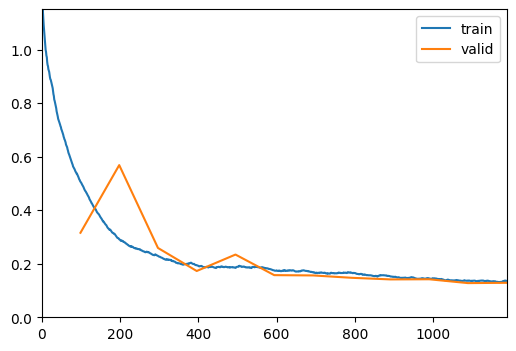

Better model found at epoch 2 with valid_loss value: 0.2589991092681885.
Better model found at epoch 3 with valid_loss value: 0.17292730510234833.
Better model found at epoch 5 with valid_loss value: 0.1574561893939972.
Better model found at epoch 6 with valid_loss value: 0.15636567771434784.
Better model found at epoch 7 with valid_loss value: 0.14751212298870087.
Better model found at epoch 8 with valid_loss value: 0.14149639010429382.
Better model found at epoch 10 with valid_loss value: 0.12770473957061768.


In [11]:
cbs = [SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(monitor='valid_loss', patience=3)]
n_epoch = 12

# Entrenar toda la red
learn.fit_one_cycle(n_epoch, cbs=cbs)

In [12]:
learn.save('/kaggle/working/residualautoencoder')

Path('/kaggle/working/residualautoencoder.pth')

### Visualizando algunas inferencias

In [17]:
model_path = Path('/kaggle/input/encoder/residualautoencoder')

# Cargar los pesos
learn.load(model_path)

In [14]:
# Realizar la validación
results = learn.validate(dl=valid_dl)

# Ver pérdida validación
print("MSE:", results[1]) 

MSE: 0.13313424587249756


In [21]:
def visualize(output: torch.Tensor, label: torch.Tensor):
    
    for i, out in enumerate(output): 
        out_np = out.squeeze().numpy()
        label_np = label[i].squeeze().numpy()

        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(out_np[1, :, :], cmap='gray')
        axs[1].imshow(label_np[1, :, :], cmap='gray')

        plt.tight_layout()
        plt.show()

In [17]:
# Realizar inferencias sobre el conjunto de datos de validación
preds, targets = learn.get_preds(ds_idx=1)  # ds_idx=1 selecciona el conjunto de datos de validación

In [ ]:
visualize(preds, targets)

## Clasificando entre Gliomas y Meningiomas

#### Redefinición de la clase de Dataset

In [15]:
# Leer los dataFrames con las rutas y los datos
train = pd.read_csv('/kaggle/input/partition/trainAtlas.csv')
valid = pd.read_csv('/kaggle/input/partition/validAtlas.csv')
test = pd.read_csv('/kaggle/input/partition/testAtlas.csv')

In [16]:
class BraTS_BIN(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS_BIN, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32
    self.label_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los path de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f', 'ruta_t2w']].tolist()
    label = self.atlas.iloc[index]['etiqueta']
    slice_num = self.atlas.iloc[index]['slice']

    brain_img = np.zeros((240, 240, 4))
    
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
      with open(img_path, 'rb') as archivo:
        current_img = nib.fileslice.fileslice(archivo, slice_num, [156, 240, 240], 'int16')       
      brain_img[:, :, idx] += standard_normalize(current_img)
        
    x = torch.from_numpy(brain_img.T).type(self.mri_dtype)
    y = torch.tensor(label, dtype=torch.long)

    del brain_img
    del current_img

    return x, y

In [18]:
class BinaryNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, encoder_model=None):
        super(BinaryNet, self).__init__()
        
        # Encoder
        self.encoder = encoder_model.encoder
        
        # Representación latente
        self.bottleneck = encoder_model.bottleneck
        
        self.flatten = nn.Flatten()
        
        # Capas densamente conectadas
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 8 * 8, 512),  # Capa lineal con 1024*8*8 entradas y 512 salidas
            nn.ReLU(),
            nn.Linear(512, 256),            # Capa lineal con 512 entradas y 256 salidas
            nn.ReLU(),
            nn.Linear(256, 128),            # Capa lineal con 256 entradas y 128 salidas
            nn.ReLU(),
            nn.Linear(128, 3)              # Capa lineal con 128 entradas y 3 salidas
        )
        
    def forward(self, x):
        o = x
            
        for layer in self.encoder:
            o = layer(o)

        o = self.bottleneck(o)
        o = self.flatten(o)
        o = self.classifier(o)
            
        return o

In [19]:
train_BIN = BraTS_BIN(train)
valid_BIN = BraTS_BIN(valid)

train_dl = DataLoader(train_BIN, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_BIN, batch_size=32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
binary_net = BinaryNet(encoder_model = learn.model).to(device)

In [20]:
# Crear el objeto Learner
balancedAccuracy = BalancedAccuracy()

dls = DataLoaders(train_dl, valid_dl)
learn_bin = Learner(
    dls=dls,  
    model=binary_net,      
    loss_func=FocalLossFlat(),    
    metrics=[accuracy, balancedAccuracy]
)

print(learn_bin.summary())

BinaryNet (Input shape: 32 x 4 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 3 x 240 x 240  
Conv2d                                    15         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                              

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.195459,0.215743,0.745439,0.607076,1:03:58
1,0.177484,0.215790,0.756223,0.719639,58:58
2,0.160405,0.181192,0.796069,0.723311,59:48
3,0.129047,0.182261,0.809142,0.743195,57:50
4,0.116504,0.203444,0.808452,0.739559,56:09
5,0.102154,0.227912,0.811712,0.746529,56:49


Better model found at epoch 0 with valid_loss value: 0.21574291586875916.


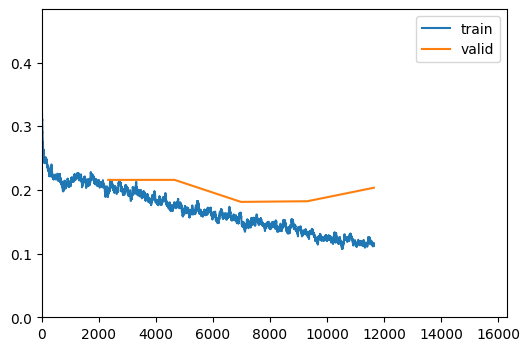

Better model found at epoch 2 with valid_loss value: 0.18119218945503235.
No improvement since epoch 2: early stopping


In [19]:
cbs = [SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(monitor='valid_loss', patience=3)]
n_epoch = 7

# Entrenar toda la red
learn_bin.fit_one_cycle(n_epoch, cbs=cbs)

#### Curva de entrenamiento obteniendo una imagen de cada resonancia por época

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,0.253449,0.244482,0.727273,0.333333,01:47
1,0.258222,0.252313,0.708625,0.347080,01:44
2,0.253457,0.214326,0.722611,0.333333,01:42
3,0.260745,0.340510,0.731935,0.333333,01:38
4,0.246629,0.222830,0.727273,0.358659,01:42
5,0.239301,0.209574,0.757576,0.333333,01:40
6,0.228284,0.237173,0.694639,0.350326,01:33


Better model found at epoch 0 with valid_loss value: 0.24448218941688538.


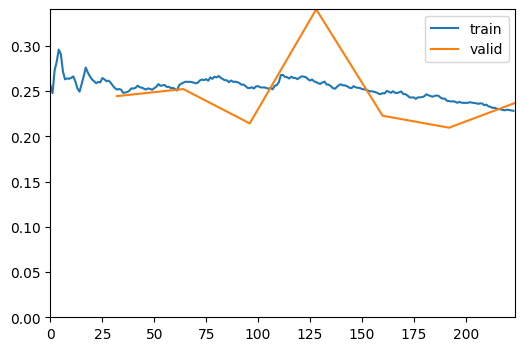

Better model found at epoch 2 with valid_loss value: 0.21432599425315857.
Better model found at epoch 5 with valid_loss value: 0.20957447588443756.


In [30]:
cbs = [SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(monitor='valid_loss', patience=3)]
n_epoch = 7

# Entrenar toda la red
learn_bin.fit_one_cycle(n_epoch, cbs=cbs)

In [20]:
learn_bin.save('/kaggle/working/ternaryclassification')

Path('/kaggle/working/ternaryclassification.pth')

In [22]:
# Cargar el modelo
model_path = Path('/kaggle/input/task1model/ternaryclassification')
learn_bin.load(model_path)

### Matrices de confusión

In [36]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

def matriz_confusion(preds, targets, conjunto='entrenamiento'):
    classes=['Meningioma', 'Glioma', 'No Tumor']
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Matriz de confusión para {conjunto}')
    plt.colorbar()

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()
    
    print(f'El accuracy balanceado en el conjunto de {conjunto} es:', balanced_accuracy_score(targets, preds))
    

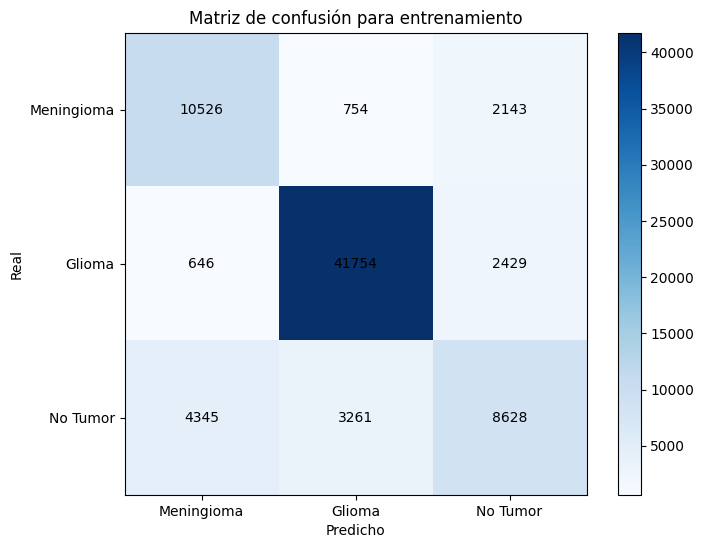

El accuracy balanceado en el conjunto de entrenamiento es: 0.7490198566167602


In [38]:
# Computamos la matriz de confusión
preds, targets = learn_bin.get_preds(dl=train_dl)
predicted = torch.argmax(preds, dim=1) # Transformar preds en un tensor de 0, 1 y 2.
matriz_confusion(predicted, targets)

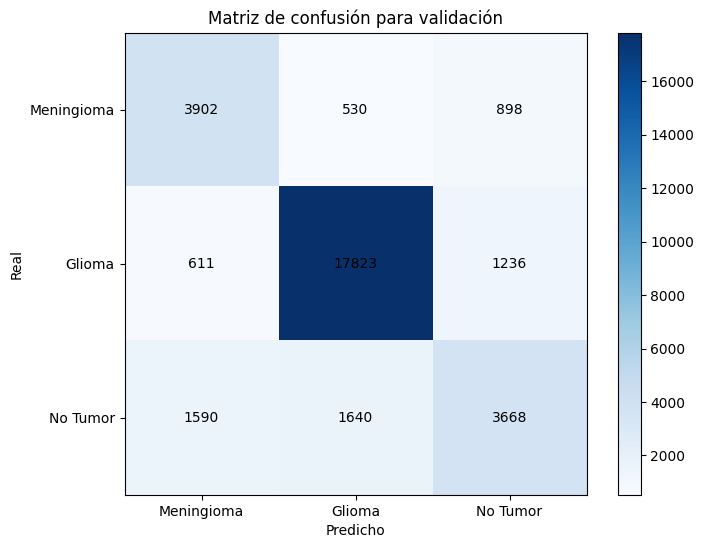

El accuracy balanceado en el conjunto de validación es: 0.7233105151165932


In [37]:
# Computamos la matriz de confusión
preds, targets = learn_bin.get_preds(dl=valid_dl)
predicted = torch.argmax(preds, dim=1) # Transformar preds en un tensor de 0, 1 y 2.
matriz_confusion(predicted, targets, conjunto='validación')

### Hacer votación con test